In [1]:
import jax.numpy as jnp
from jax import random
from jax import vmap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import norm
import pandas as pd
from IPython.display import display, HTML

In [ ]:
data = jnp.load('Gustav/data_assignment3.npz')
x_data, y_data = data['x'], data['t']

In [3]:
design_matrix = lambda x: np.column_stack((x,np.ones(len(x))))

In [4]:
# Normal distribution
def log_npdf(x, m, v):
    return -0.5 * (x - m) ** 2 / (v) - 0.5 * jnp.log(2 * jnp.pi * v)


def npdf(x, m, v):
    return jnp.exp(log_npdf(x, m, v))


# Half-normal distribution
def log_half_npdf(x, m, v):
    return jnp.log(2) - 0.5 * (x - m) ** 2 / (v) - 0.5 * jnp.log(2 * jnp.pi * v)


def half_npdf(x, m, v):
    return jnp.exp(log_half_npdf(x, m, v))

# Logistic function
def sigmoid(z):
    return 1 / (1 + jnp.exp(-z))

In [5]:
def plot_summary(
    ax,
    x,
    s,
    interval=95,
    num_samples=0,
    sample_color="k",
    sample_alpha=0.4,
    interval_alpha=0.25,
    color="r",
    legend=True,
    title="",
    plot_mean=True,
    plot_median=False,
    label="",
    seed=0,
):
    b = 0.5 * (100 - interval)
    lower = jnp.percentile(s, b, axis=0).T
    upper = jnp.percentile(s, 100 - b, axis=0).T

    if plot_median:
        median = jnp.percentile(s, 50, axis=0).T
        lab = "Median"
        if label:
            lab += " " + label
        ax.plot(x.ravel(), median, label=lab, color=color, linewidth=4)

    if plot_mean:
        mean = jnp.mean(s, axis=0).T
        lab = "Mean"
        if label:
            lab += " " + label
        ax.plot(x.ravel(), mean, "--", label=lab, color=color, linewidth=4)

    ax.fill_between(
        x.ravel(),
        lower.ravel(),
        upper.ravel(),
        color=color,
        alpha=interval_alpha,
        label=f"{interval}% Interval",
    )

    if num_samples > 0:
        np.random.seed(seed)
        idx_samples = np.random.choice(s.shape[0], size=num_samples, replace=False)
        ax.plot(x, s[idx_samples, :].T, color=sample_color, alpha=sample_alpha)

    if legend:
        ax.legend(loc="best")

    if title:
        ax.set_title(title, fontweight="bold")

## Part 2: Regression modelling using mixture of experts

*Mixture of experts (MoE) model for regression*

We consider two different linear models $\boldsymbol{y}_n= \boldsymbol{w}_0^T\boldsymbol{x}_n + e_n$ and $\boldsymbol{y}_n= \boldsymbol{w}_1^T\boldsymbol{x}_n +e_n$, with weights $\boldsymbol{w}_0$ and $\boldsymbol{w}_1$ in respect to two different regions of $\boldsymbol{x}_n$, controlled by the latent variable $z_n \in \{0,1\}$ which we let be Bernoulli distributed given the data $\boldsymbol{x}_n$ 
$$
z_n \mid \boldsymbol{v} \sim \operatorname{Ber}\left(\sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\right),
$$
where $\boldsymbol(v)$ are parameters and $\boldsymbol{x}_n=[x_n,1]$.\
We then construct the conditional likelyhood as Gaussians for both data regions determined by the latent variable such that
$$
\begin{align*}
p\left(y_n \mid x_n, z_n, \boldsymbol{w}_0, \boldsymbol{w}_1, \sigma_0^2, \sigma_1^2\right)=\left\{\begin{array}{lll}
\mathcal{N}\left(y_n \mid \boldsymbol{w}_1^T \boldsymbol{x}_n, \sigma_1^2\right) & \text { if } & z_n=1, \\
\mathcal{N}\left(y_n \mid \boldsymbol{w}_0^T \boldsymbol{x}_n, \sigma_0^2\right) & \text { if } & z_n=0,
\end{array}=\mathcal{N}\left(y_n \mid \boldsymbol{w}_{z_n}^T \boldsymbol{x}_n, \sigma_{z_n}^2\right)\right.,
\end{align*}
$$
with noise variance $\sigma_{z_n}^2$. Adding the following generic priors, we write up the joint distribution
$$
\begin{align*}
\tau, \sigma_0, \sigma_1 & \sim \mathcal{N}_{+}(0,1), \\
w_0, w_1, \boldsymbol{v} & \sim \mathcal{N}\left(\mathbf{0}, \tau^2 \boldsymbol{I}\right), \\
y_n \mid z_n & \sim \mathcal{N}\left(\boldsymbol{w}_{z_n}^T \boldsymbol{x}_n, \sigma_{z_n}^2\right),
\end{align*}
$$
joint distribution:
$$

\begin{align*}
p\left(\boldsymbol{y}, \boldsymbol{w}_1, \boldsymbol{w}_0, \boldsymbol{v}, \boldsymbol{z}, \tau, \sigma_0, \sigma_1 \mid \boldsymbol{x}\right)= & {\left[\prod_{n=1}^N \mathcal{N}\left(y_n \mid \boldsymbol{w}_{z_n}^T \boldsymbol{x}_n, \sigma_{z_n}^2\right) \operatorname{Ber}\left(z_n \mid \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\right)\right] \mathcal{N}\left(\boldsymbol{w}_0 \mid \mathbf{0}, \tau^2 \boldsymbol{I}\right) } \\
& \mathcal{N}\left(\boldsymbol{w}_1 \mid \mathbf{0}, \tau^2 \boldsymbol{I}\right) \mathcal{N}\left(\boldsymbol{v} \mid \mathbf{0}, \tau^2 \boldsymbol{I}\right) \mathcal{N}_{+}\left(\tau \mid 0,1\right) \mathcal{N}_{+}\left(\sigma_0 \mid 0,1\right) \mathcal{N}_{+}\left(\sigma_1 \mid 0,1\right).
\end{align*}
$$


**Task 2.1: Marginalize out each $z_n$ from to joint model.**

Using the sum rule we marginalize out $z_n$ from the joint distribution. Remembering that $z_n$ is discrete, we have to sum and not integrate over $z_n$.

To simplify the sum, we will denote all Gaussians that are not dependent on $z_n$ as $p\left(\neg \boldsymbol{z} \right)$ and sum over all $2^N$ combinations of $z_n$, $\boldsymbol{z}=\{z_n\}_{n=1}^N$. Since each observation is independent of each other, we can move the sum inside the product $\left(\sum_{\boldsymbol{z}}= \sum_{z_1}\sum_{z_2}...\sum_{z_N}=\prod_{n=1}^N\sum_{z_n}\right)$.

$$
\begin{align*}
\sum_{\boldsymbol{z}} p\left(\boldsymbol{y}, \boldsymbol{w}_1, \boldsymbol{w}_0, \boldsymbol{v}, \boldsymbol{z}, \tau, \sigma_0, \sigma_1 \mid \boldsymbol{x}\right) 
&=
p\left(\neg \boldsymbol{z}\right) \sum_{\boldsymbol{z}} {\left[\prod_{n=1}^N \mathcal{N}\left(y_n \mid \boldsymbol{w}_{z_n}^T \boldsymbol{x}_n, \sigma_{z_n}^2\right) \operatorname{Ber}\left(z_n \mid \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\right)\right]}\\
&= 
p\left(\neg \boldsymbol{z}\right) \left[\prod_{n=1}^N\sum_{\boldsymbol{z}_n} \mathcal{N}\left(y_n \mid \boldsymbol{w}_{z_n}^T \boldsymbol{x}_n, \sigma_{z_n}^2\right) \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)^{z_n}(1-\sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right))^{1-z_n}\right]\\

&=
p\left(\neg \boldsymbol{z}\right) \prod_{n=1}^N \underbrace{\bigg[ \mathcal{N}\left(y_n \mid \boldsymbol{w}_{1}^T \boldsymbol{x}_n, \sigma_{1}^2\right) \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right) + \mathcal{N}\left(y_n \mid \boldsymbol{w}_{0}^T \boldsymbol{x}_n, \sigma_{0}^2\right)\sigma\left(-\boldsymbol{v}^T \boldsymbol{x}_n\right)\bigg]}_{\text{Likelihood for each observation}}

\end{align*}
$$

We see that the likelihood for each observation has become a mixture of gaussians after the marginalization of $z_n$.

**Task 2.2: Python function to evaluate the marginalized log joint distribution**


We will separate the terms from above, such that we have:

$$
\begin{align*}
\log{p\left(\boldsymbol{y}, \boldsymbol{w}_0, \boldsymbol{w}_1, \boldsymbol{v}, \tau, \sigma_0, \sigma_1|\boldsymbol{x}\right)} 
&= 
\log{p(\neg \boldsymbol{z})} + \log{p\left(\boldsymbol{y} \mid \boldsymbol{x}, \boldsymbol{w}_0, \boldsymbol{w}_1, \boldsymbol{v}, \sigma_0, \sigma_1 \right)}\\
\\
\log{p(\neg \boldsymbol{z})} &= - 3\log (2\pi) - 6\log\tau - \frac{\boldsymbol{w_0}^T\boldsymbol{w_0}+\boldsymbol{w_1}^T\boldsymbol{w_0}+\boldsymbol{v}^T\boldsymbol{v}}{2\tau^2} 
+ \frac32\log(2) - \frac 32\log (\pi) - \frac{\tau^2+\sigma_0^2+\sigma_1^2}{2}\\
\\
\log{p\left(\boldsymbol{y} \mid \boldsymbol{x}, \boldsymbol{w}_0, \boldsymbol{w}_1, \boldsymbol{v}, \sigma_0, \sigma_1 \right)}
&=
\sum_{n=1}^N {\log{\bigg[ \mathcal{N}\left(y_n \mid \boldsymbol{w}_{1}^T \boldsymbol{x}_n, \sigma_{1}^2\right) \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right) + \mathcal{N}\left(y_n \mid \boldsymbol{w}_{0}^T \boldsymbol{x}_n, \sigma_{0}^2\right)\sigma\left(-\boldsymbol{v}^T \boldsymbol{x}_n\right)\bigg]}}

\end{align*}
$$

We see that we can vectorize the Gaussian mixture terms wrt. the number of data points for the logaritmic transformation which was not possible for the joint distribution.

In [ ]:
def log_joint(y, x, theta):
    """
    Evaluates the log joint distribution

    Parameters:
      y      : array of N observations (shape: (N,))
      x      : design matrix for N observations (shape: (N,2)); each row is [x_n, 1]
      theta  : vector of parameters of shape (9,), where
               theta[0:2]  -> w0 (slope and intercept)
               theta[2:4]  -> w1 (slope and intercept)
               theta[4:6]  -> v  (slope and intercept)
               theta[6]    -> tau
               theta[7]    -> sigma0
               theta[8]    -> sigma1

    Returns:
      log joint density evaluated at theta.
    """

    # Unpack parameters
    w0 = theta[0:2]
    w1 = theta[2:4]
    v = theta[4:6]
    tau = theta[6]
    sigma0 = theta[7]
    sigma1 = theta[8]


    # ---------- Prior term (log p(~z)) ----------
    # log p(~z) = - 3log(2pi) - 6log(tau) - (w0^T w0 + w1^T w1 + v^T v)/(2*tau^2)
    #           + 1.5 log(2) - 1.5 log(pi) - (tau^2+sigma0^2+sigma1^2)/2
    log_p_neg_z = (
        -3 * jnp.log(2 * jnp.pi)
        - 6 * jnp.log(tau)
        - (jnp.dot(w0, w0) + jnp.dot(w1, w1) + jnp.dot(v, v)) / (2 * tau**2)
        + 1.5 * jnp.log(2)
        - 1.5 * jnp.log(jnp.pi)
        - (tau**2 + sigma0**2 + sigma1**2) / 2
    )

    # ---------- Likelihood term ----------
    # Compute predictions:
    # For each observation x_n (a row vector of shape (2,)), we compute:
    #   m1 = w1^T x_n, m0 = w0^T x_n, and v_dot = v^T x_n
    m1 = jnp.sum(x * w1, axis=1)
    m0 = jnp.sum(x * w0, axis=1)
    v_dot = jnp.sum(x * v, axis=1)

    # For each observation, form the likelihood contribution (a mixture) as:
    # term1 = N(y_n | m1, sigma1^2) * sigmoid(v_dot)
    # term2 = N(y_n | m0, sigma0^2) * sigmoid(-v_dot)
    term1 = jnp.exp(log_npdf(y, m1, sigma1**2)) * sigmoid(v_dot)
    term2 = jnp.exp(log_npdf(y, m0, sigma0**2)) * sigmoid(-v_dot)

    # Sum of both (for each observation) and then take the log and sum over all data points.
    log_likelihood = jnp.sum(jnp.log(term1 + term2))



    return log_p_neg_z + log_likelihood

**Task 2.3: Metropolis-Hasting sampler to infer all parameters**

Below is the code for the Metropolis-Hasting sampler, 'MetH'. Since the we have a mixed Gaussian as target distribution, we use unimodal Gaussians as proposal distributions for the parameters.

In [7]:
def MetH(log_target, num_params, tau, num_iter, theta_init=None, seed=0):
    """Runs a Metropolis-Hastings sampler

    Arguments:
    log_target:         function for evaluating the log target distribution, i.e. log \tilde{p}(theta). The function expect a parameter of size num_params.
    num_params:         number of parameters of the joint distribution (integer)
    tau:                standard deviation of the Gaussian proposal distribution (positive real)
    num_iter:           number of iterations (integer)
    theta_init:         vector of initial parameters (np.array with shape (num_params) or None)
    seed:               seed (integer)

    returns
    thetas              np.array with MCMC samples (np.array with shape (num_iter+1, num_params))
    """

    # set initial key
    key = random.PRNGKey(seed)

    if theta_init is None:
        theta_init = jnp.zeros((num_params))

    # prepare lists
    thetas = [theta_init]
    accepts = []
    log_p_theta = log_target(theta_init)

    for k in range(num_iter):

        # update keys: key_proposal for sampling proposal distribution and key_accept for deciding whether to accept or reject.
        key, key_proposal, key_accept = random.split(key, num=3)

        # get the last value for theta and generate new proposal candidate
        theta_cur = thetas[-1]
        theta_star = theta_cur + tau * random.normal(key_proposal, shape=(num_params,))

        # evaluate the log density for the candidate sample
        log_p_theta_star = log_target(theta_star)

        # compute acceptance probability
        log_r = log_p_theta_star - log_p_theta
        A = min(1, jnp.exp(log_r))

        # accept new candidate with probability A
        if random.uniform(key_accept) < A:
            theta_next = theta_star
            log_p_theta = log_p_theta_star
            accepts.append(1)
        else:
            theta_next = theta_cur
            accepts.append(0)

        thetas.append(theta_next)

    print("Acceptance ratio: %3.2f" % jnp.mean(jnp.array(accepts)))

    # return as np.array
    thetas = jnp.stack(thetas)

    # check dimensions and return
    assert thetas.shape == (
        num_iter + 1,
        num_params,
    ), f"The shape of thetas was expected to be ({num_iter+1}, {num_params}), but the actual shape was {thetas.shape}. Please check your code."
    return thetas

Looking at the data and the derived log joint distribution, we expect $z_n=1$ to be the first part with a positive slope and $z_n=0$ to be the second part with a negative slope. Because of this convention, we expect the slope parameter of $\boldsymbol{v}$ to be negative. We also notice the variance for the data points in region $z_n=0$ is much larger than in the in region $z_n=1$. With good initial guesses for the parameters, we might have a good chance of being close to convergence (for relatively few iterations), when picking a low proposal variance to get a high accpetance ratio.

Hence, we guess for the parameters to be around:
$$
\begin{equation*}
\theta = \left[ \boldsymbol{w}_0 = \binom{-3}{0},\ \boldsymbol{w}_1 = \binom{2}{0},\
\boldsymbol{v} = \binom{-1}{1},\ \tau = 1,\ \sigma_0 = 2,\ \sigma_1 = 1  \right]
\end{equation*}
$$

We set the variance of the proposal distribution to 0.2 (called step_size in code) and run the sampler for 20.000 iterations. We expect higher acceptance ratio with the low proposal variance, thus we need a relatively large number of iterations to ensure convergence.

Acceptance ratio: 0.07


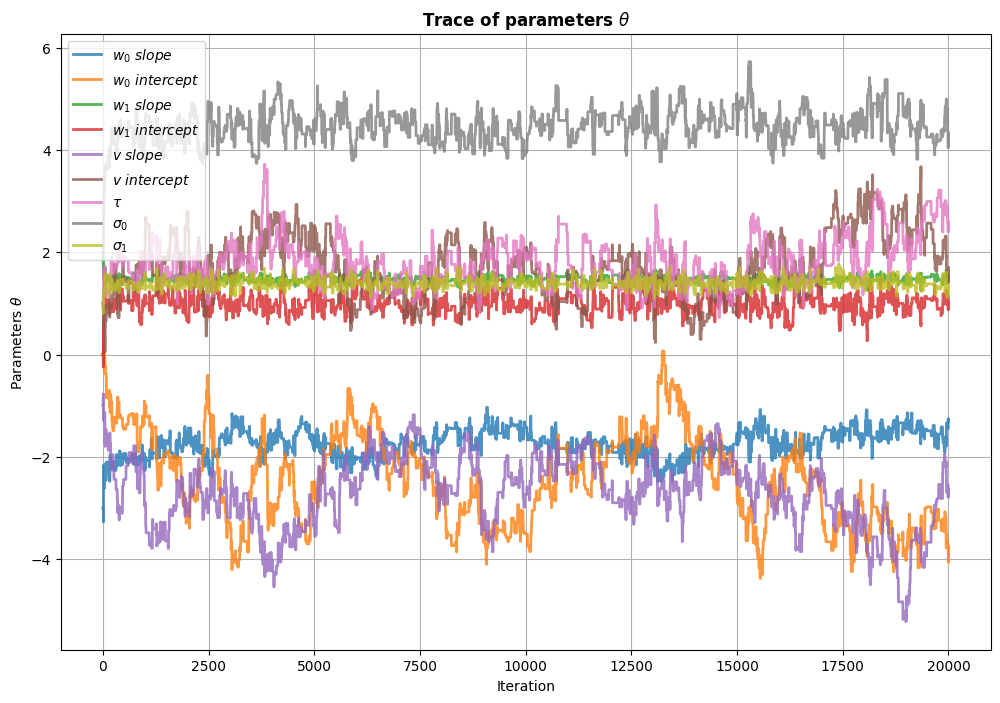

In [20]:

# specify number of parameters in the target distribution
num_params = 9

# target distribution = log joint distribution

num_iterations = 20000

# proposal variance for each parameter
step_size = 0.2

# theta = {w0[0], w0[1], w1[0], w1[1], v[0], v[1], tau, sigm0, sigma1}
theta_lab = [r'$w_0\ slope$', r'$w_0\ intercept$', r'$w_1\ slope$', r'$w_1\ intercept$',
            r'$v\ slope$', r'$v\ intercept$', r'$\tau$', r'$\sigma_0$', r'$\sigma_1$']

w0_init = [-3.0, 0.0]
w1_init = [2.0,0.0]
v_init = [-1.0, 1.0]
tau_init = [1.0]
sigma0_init = [2.0]
sigma1_init = [1.0]
theta_init = jnp.array(w0_init + w1_init + v_init + tau_init + sigma0_init + sigma1_init)

p_target = lambda theta: log_joint(y_data, design_matrix(x_data), theta)

# run sampler
thetas = MetH(p_target, num_params, step_size, num_iterations, theta_init=theta_init, seed=0)

# plot resutls
xs = np.linspace(-12, 12, 1000)
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
for i in range(num_params):
    axes.plot(thetas[:,i], alpha=0.8, linewidth=2,label=theta_lab[i])
axes.set_xlabel('Iteration')
axes.set_ylabel('Parameters $\\theta$')
axes.set_title('Trace of parameters $\\theta$', fontweight='bold')
axes.legend()
axes.grid()
plt.show()



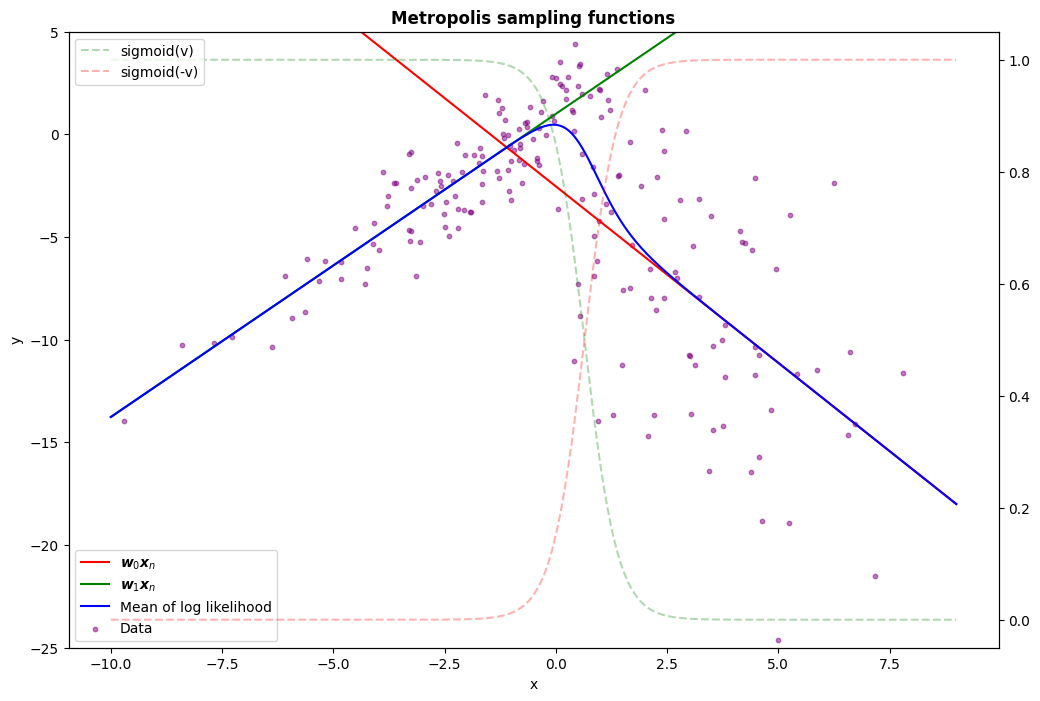

In [30]:
warm_up = int(0.2*num_iterations)
theta_mean = np.mean(thetas[warm_up:], axis=0)

w0 = jnp.array([theta_mean[0],theta_mean[1]])
w1 = jnp.array([theta_mean[2],theta_mean[3]])
v = jnp.array([theta_mean[4],theta_mean[5]])
tau = theta_mean[6]
sigma0 = theta_mean[7]
sigma1 = theta_mean[8]
x = np.linspace(-10, 9, 500)

# design matrix
X = design_matrix(x)
X1 = X@w1
X0 = X@w0

fig, axes = plt.subplots(1,1, figsize=(12, 8))

#### Metro-Hastings samples mean:

y = sigmoid(X@v)*X1 + sigmoid(-X@v)*X0
ax2 = axes.twinx()

ax2.plot(x,sigmoid(X@v),'--', color='green', alpha=0.3, label='sigmoid(v)')
ax2.plot(x,sigmoid(-X@v),'--', color='red', alpha=0.3, label='sigmoid(-v)')
ax2.legend(loc='upper left')

axes.plot(x, X0, color='red', label=r'$\boldsymbol{w}_0 \boldsymbol{x}_n$')
axes.plot(x, X1, color='green', label=r'$\boldsymbol{w}_1 \boldsymbol{x}_n$')
axes.plot(x, y, color='blue', label='Mean of log likelihood')

# plot contour of log joint distribution and data
axes.set_title('Metropolis sampling functions', fontweight='bold')
axes.set_xlabel('x')
axes.set_ylabel('y')

#log_joint_vectorized = vmap(lambda xi, yi: log_joint(yi, xi, theta_mean))
axes.set_ylim(-25,5)
axes.scatter(x_data, y_data, c='purple', s=10, alpha=0.5, label='Data')
axes.legend(loc='lower left')


**Task 2.4: posterior mean and 95% credibility intervals for all parameters**

In [25]:

# Assuming you already have these:
# thetas, warm_up, theta_init

theta_sample = thetas[warm_up:, :]

# Round to 3 decimals
lower = jnp.round(jnp.percentile(theta_sample, 2.5, axis=0), 3)
upper = jnp.round(jnp.percentile(theta_sample, 97.5, axis=0), 3)
mean = jnp.round(jnp.mean(theta_sample, axis=0), 3)

# Labels with HTML
labels = [
    'w<sub>0</sub>: slope', 'w<sub>0</sub>: intercept', 
    'w<sub>1</sub>: slope', 'w<sub>1</sub>: intercept', 
    'v slope', 'v intercept', 
    '&#x03C4;',              # τ
    '&#x03C3;<sub>0</sub>',  # σ₀
    '&#x03C3;<sub>1</sub>'   # σ₁
]

# Format the intervals as strings: "[lower, upper]"
low_up = [f"[{l:.3f} ; {u:.3f}]" for l, u in zip(lower, upper)]

# Create DataFrame
cred_int = pd.DataFrame({
    'Parameter': labels,
    'Initial': theta_init,
    'Mean': mean,
    '95%-Credibility interval': low_up,
})

cred_int = cred_int.set_index('Parameter')

# Display with HTML rendering
display(HTML(cred_int.to_html(escape=False)))


,Initial,Mean,95%-Credibility interval
Parameter,,,
w0: slope,-3.0,-1.719,[-2.241 ; -1.291]
w0: intercept,0.0,-2.528,[-3.897 ; -0.686]
w1: slope,2.0,1.476,[1.356 ; 1.595]
w1: intercept,0.0,0.997,[0.631 ; 1.363]
v slope,-1.0,-2.682,[-4.247 ; -1.534]
v intercept,1.0,1.727,[0.648 ; 2.991]
τ,1.0,1.821,[1.051 ; 2.970]
σ0,2.0,4.499,[3.926 ; 5.148]
σ1,1.0,1.396,[1.208 ; 1.595]


**Task 2.5: Plot posterior predictive distribution for $p(\pi^*\mid\boldsymbol{y},\boldsymbol{x}^*),\ p(y^*\mid\boldsymbol{y},\boldsymbol{x}^*,z^*=0)$** **and** $p(y^*\mid\boldsymbol{y},\boldsymbol{x}^*,z^*=1)$

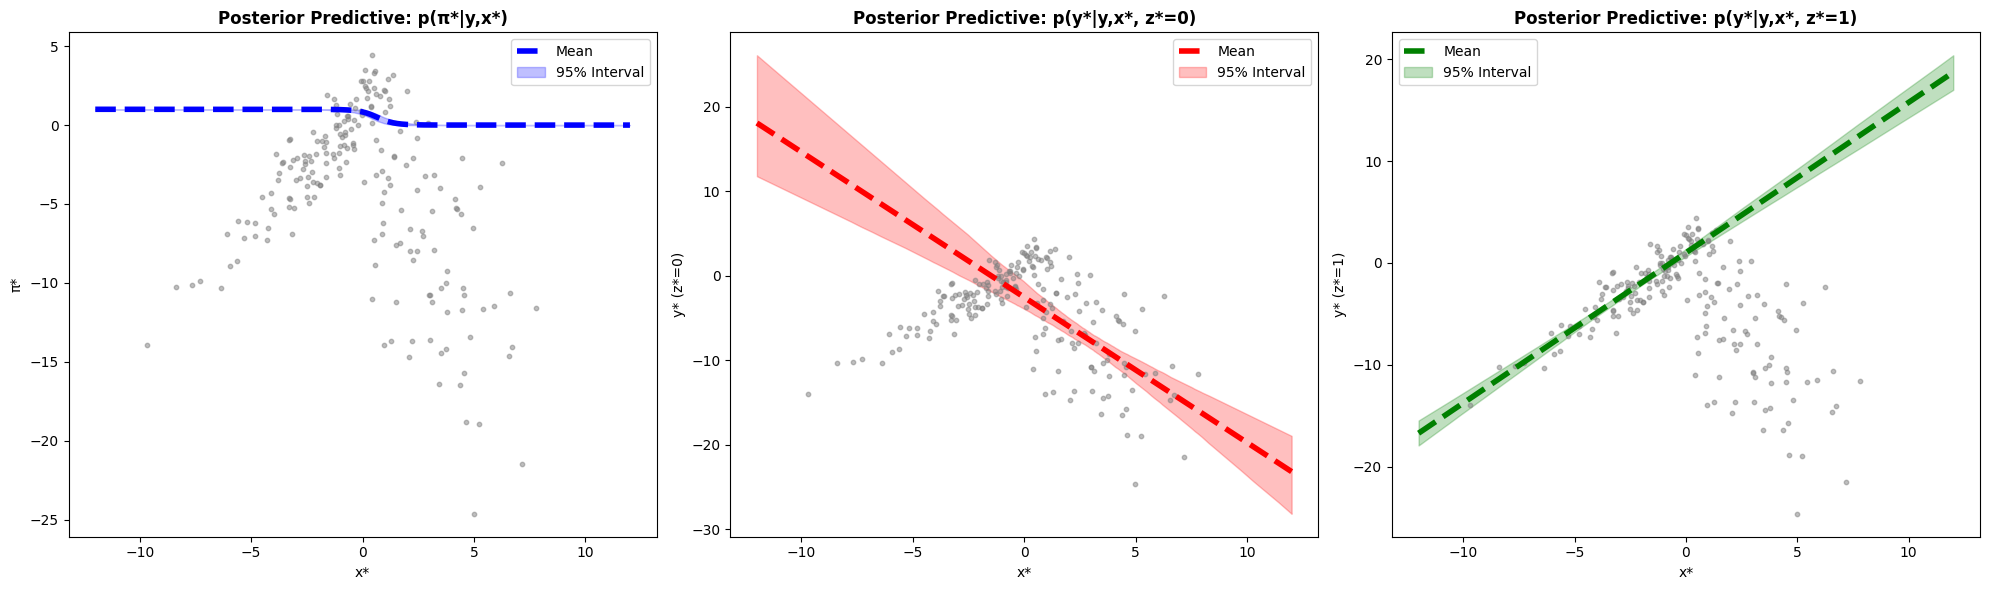

In [26]:
# ---------------------------
# Compute posterior predictive samples
# ---------------------------
# Create new x* values
x_star = jnp.linspace(-12, 12, 1000)
X_star = design_matrix(x_star)  # design matrix (1000, 2)

# Assume theta_sample is available from your MCMC sampler (shape: (M, 9))
# Extract the relevant posterior samples:
#   w0_samples: parameters for branch z=0, shape (M, 2)
#   w1_samples: parameters for branch z=1, shape (M, 2)
#   v_samples : parameters for mixing, shape (M, 2)
w0_samples = theta_sample[:, 0:2]
w1_samples = theta_sample[:, 2:4]
v_samples = theta_sample[:, 4:6]

# For each sample we compute the predictive functions:
#   π* = sigmoid(X_star @ v)
#   y*|z*=0 = X_star @ w0
#   y*|z*=1 = X_star @ w1

# Compute π* samples: iterate over M samples to get an array of shape (M, len(x_star))
pi_star_samples = jnp.array(
    [sigmoid(X_star @ v_samples[i]) for i in range(v_samples.shape[0])]
)
# Compute y* samples for branch z*=0
y_star_z0_samples = jnp.array(
    [X_star @ w0_samples[i] for i in range(w0_samples.shape[0])]
)
# Compute y* samples for branch z*=1
y_star_z1_samples = jnp.array(
    [X_star @ w1_samples[i] for i in range(w1_samples.shape[0])]
)

# ---------------------------
# Plot predictions on top of the data
# ---------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot posterior predictive for π*
plot_summary(
    axes[0],
    x_star,
    pi_star_samples,
    title="Posterior Predictive: p(π*|y,x*)",
    color="blue",
)
axes[0].set_xlabel("x*")
axes[0].set_ylabel("π*")
axes[0].scatter(
    np.array(x_data), np.array(y_data), color="grey", s=10, alpha=0.5, label="Data"
)

# Plot posterior predictive for y* with z* = 0
plot_summary(
    axes[1],
    x_star,
    y_star_z0_samples,
    title="Posterior Predictive: p(y*|y,x*, z*=0)",
    color="red",
)
axes[1].set_xlabel("x*")
axes[1].set_ylabel("y* (z*=0)")
axes[1].scatter(
    np.array(x_data), np.array(y_data), color="grey", s=10, alpha=0.5, label="Data"
)

# Plot posterior predictive for y* with z* = 1
plot_summary(
    axes[2],
    x_star,
    y_star_z1_samples,
    title="Posterior Predictive: p(y*|y,x*, z*=1)",
    color="green",
)
axes[2].set_xlabel("x*")
axes[2].set_ylabel("y* (z*=1)")
axes[2].scatter(
    np.array(x_data), np.array(y_data), color="grey", s=10, alpha=0.5, label="Data"
)

plt.tight_layout()
plt.show()

**Task 2.6: Plot posterior predictive distribution for $p(y^*\mid\boldsymbol{y},\boldsymbol{x}^*)$**

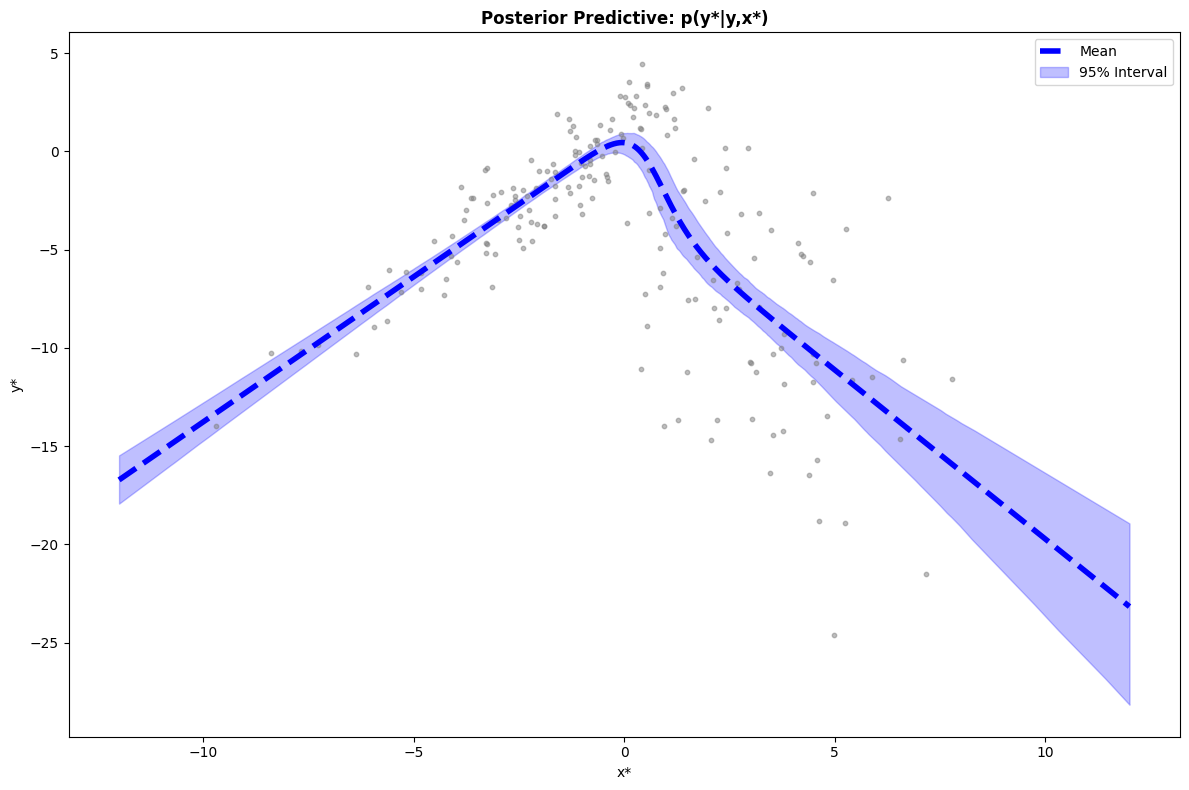

In [27]:
# Create new x* values
x_star = jnp.linspace(-12, 12, 1000)
X_star = design_matrix(x_star)  # design matrix (1000, 2)

# Extract posterior samples from theta_sample (shape: (M,9))
w0_samples = theta_sample[:, 0:2]
w1_samples = theta_sample[:, 2:4]
v_samples  = theta_sample[:, 4:6]

# Compute predictive y* for each sample:
# y* = sigmoid(X_star @ v) * (X_star @ w1) + (1 - sigmoid(X_star @ v)) * (X_star @ w0)
y_star_pred_samples = jnp.array([
    sigmoid(X_star @ v_samples[i]) * (X_star @ w1_samples[i]) +
    (1 - sigmoid(X_star @ v_samples[i])) * (X_star @ w0_samples[i])
    for i in range(theta_sample.shape[0])
])

# Plot using plot_summary on top of the data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_summary(ax, x_star, y_star_pred_samples, title="Posterior Predictive: p(y*|y,x*)", color="blue")
ax.set_xlabel("x*")
ax.set_ylabel("y*")
ax.scatter(np.array(x_data), np.array(y_data), color="grey", s=10, alpha=0.5, label="Data")
plt.tight_layout()
plt.show()